<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Tabnet-as-event-encoder" data-toc-modified-id="Tabnet-as-event-encoder-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Tabnet as event encoder</a></span></li></ul></div>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

sns.set_style("whitegrid", {'axes.grid' : False})

from tqdm.auto import tqdm

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import torch
torch.cuda.is_available()

True

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [5]:
from pytorch_metric_learning import losses, miners, distances, reducers, samplers
import torch.optim as optim
from sklearn.model_selection import train_test_split
import torch.nn as nn
import random
from pytorch_tabnet.tab_network import TabNet

In [6]:
from code.dataloader_handmade import AgeGroupHandmadeDataset
from code.encoder_tabnet import Encoder
from code.decoder import Decoder
from code.classifier import Classifier
from code.utils import train_ml_model, train_classifier, train_tabnet

In [25]:
BATCH_SIZE = 64 # BATCH_SIZE unique persons
NUM_OF_SUBSEQUENCES = 5
SUBSEQUENCE_LENGTH = 90

EMBEDDING_DIM = 256
LR = 0.002
NUM_EPOCHS = 200

cat_vocab_sizes = [204]
cat_embedding_dim = 20
num_input_dim = 4
NUM_OBS = 30000

In [19]:
dataset = AgeGroupHandmadeDataset()

In [27]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

In [28]:
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=BATCH_SIZE,
    num_workers=0,
)

# targets = clfdataset.targets

# train_idx, test_idx= train_test_split(
#     np.arange(len(targets)),
#     test_size=0.3,
#     shuffle=True,
#     stratify=targets,
#     random_state=228
# )

# train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
# test_sampler = torch.utils.data.SubsetRandomSampler(test_idx)

# trainloader = torch.utils.data.DataLoader(
#     clfdataset, batch_size=BATCH_SIZE,
#     sampler=train_sampler)
# testloader = torch.utils.data.DataLoader(
#     clfdataset, batch_size=BATCH_SIZE,
#     sampler=test_sampler)

## Tabnet as event encoder

In [29]:
LR = 0.002

encoder = TabNet(input_dim=dataset[0][0].shape[0],
                output_dim=EMBEDDING_DIM,
                n_d=8,
                n_a=8,
                n_steps=3,
                gamma=1.3,
                cat_idxs=[],
                cat_dims=[],
                #cat_emb_dim=cat_embedding_dim,
                n_independent=2,
                n_shared=2,
                epsilon=1e-15,
                virtual_batch_size=128,
                momentum=0.02,
                mask_type="sparsemax")

encoder.to(device);
optimizer = optim.Adam(encoder.parameters(), lr=LR)

distance = distances.CosineSimilarity()
reducer = reducers.ThresholdReducer(low = 0) # basically, returns average
loss_func = losses.TripletMarginLoss(margin = 1000, distance = distance, reducer = reducer)
mining_func = miners.TripletMarginMiner(margin = 1000, distance = distance, type_of_triplets = "all")

In [30]:
train_losses = train_tabnet(
    encoder, NUM_EPOCHS, dataloader,
    mining_func, loss_func, optimizer)

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 0 Loss = 999.9993286132812
Epoch 1 Loss = 999.9962768554688
Epoch 2 Loss = 999.9564819335938
Epoch 3 Loss = 999.8687744140625
Epoch 4 Loss = 999.80859375
Epoch 5 Loss = 999.7434692382812
Epoch 6 Loss = 999.714111328125
Epoch 7 Loss = 999.7019653320312
Epoch 8 Loss = 999.6814575195312
Epoch 9 Loss = 999.6799926757812
Epoch 10 Loss = 999.6946411132812
Epoch 11 Loss = 999.6915283203125
Epoch 12 Loss = 999.6801147460938
Epoch 13 Loss = 999.658203125
Epoch 14 Loss = 999.6691284179688
Epoch 15 Loss = 999.6688842773438
Epoch 16 Loss = 999.66455078125
Epoch 17 Loss = 999.659912109375
Epoch 18 Loss = 999.6807861328125
Epoch 19 Loss = 999.6549072265625
Epoch 20 Loss = 999.6569213867188
Epoch 21 Loss = 999.6578369140625
Epoch 22 Loss = 999.6395263671875
Epoch 23 Loss = 999.6395263671875
Epoch 24 Loss = 999.6446533203125
Epoch 25 Loss = 999.6481323242188
Epoch 26 Loss = 999.6378784179688
Epoch 27 Loss = 999.6517333984375
Epoch 28 Loss = 999.6536254882812
Epoch 29 Loss = 999.6327514648438
Epo

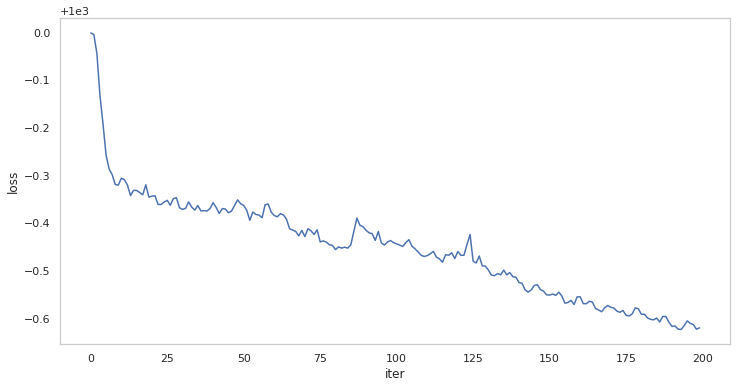

In [32]:
fig, axs = plt.subplots(figsize=(12, 6))

plt.plot(train_losses, label='train')
plt.xlabel('iter')
plt.ylabel('loss');
plt.savefig(f'plots/ML_tabnet_{EMBEDDING_DIM}_{NUM_OBS}_{NUM_EPOCHS}.png')